In [1]:
import os
import sys

project_root = os.path.split(os.getcwd())[0]
print("project_root:", project_root)
if project_root not in sys.path:
    sys.path.append(project_root)                        

project_root: /home/kurbanov/deploy/behavox


In [84]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from laughter_prediction.predictors import MiniXgboostPredictor, StrictLargeXgboostPredictor, AutoMlPredictor
from laughter_classification.visualization import plot_sequence
from sklearn.model_selection import StratifiedKFold

import numpy as np
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt

In [3]:
nrows = 50000
features_df = pd.read_csv("../features/feaures_pyAA_all_10ms.csv", nrows=nrows)
# features_df = pd.read_csv("../features/feaures_pyAA_all_10ms.csv")

In [4]:
features_df.SNAME.unique()

array(['S1544', 'S0766', 'S2541', 'S1718', 'S1860', 'S0199', 'S0558',
       'S1115', 'S2733', 'S1848', 'S2755', 'S0398', 'S2261', 'S1217',
       'S0131', 'S0475', 'S0842', 'S2043', 'S1724', 'S2516', 'S2312',
       'S0657', 'S1003', 'S2577', 'S1050', 'S1605', 'S2291', 'S1318',
       'S1302', 'S1385', 'S0795', 'S1493', 'S0503', 'S1599', 'S1171',
       'S2085', 'S0064', 'S2216', 'S0411', 'S1877', 'S1749', 'S1121',
       'S2569', 'S1842', 'S0014', 'S0874'], dtype=object)

In [5]:
# some_sname = features_df.SNAME[0]
some_sname = "S0199"
dff = features_df[features_df.SNAME == some_sname]
dff.shape

(1100, 104)

In [6]:
nfeatures = dff.shape[1] - 2
X = dff.iloc[:, :nfeatures].as_matrix()
y = dff.IS_LAUGHTER.as_matrix()

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
X.shape

(1100, 102)

In [9]:
predictor = MiniXgboostPredictor()

/home/kurbanov/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
only_features = dff.loc[:, :'pyAA101']

In [11]:
predicted = predictor.predict_proba(only_features.as_matrix())

In [12]:
predicted

array([ 0.15929481,  0.15929481,  0.14628178, ...,  0.17620879,
        0.18290374,  0.15029658], dtype=float32)

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


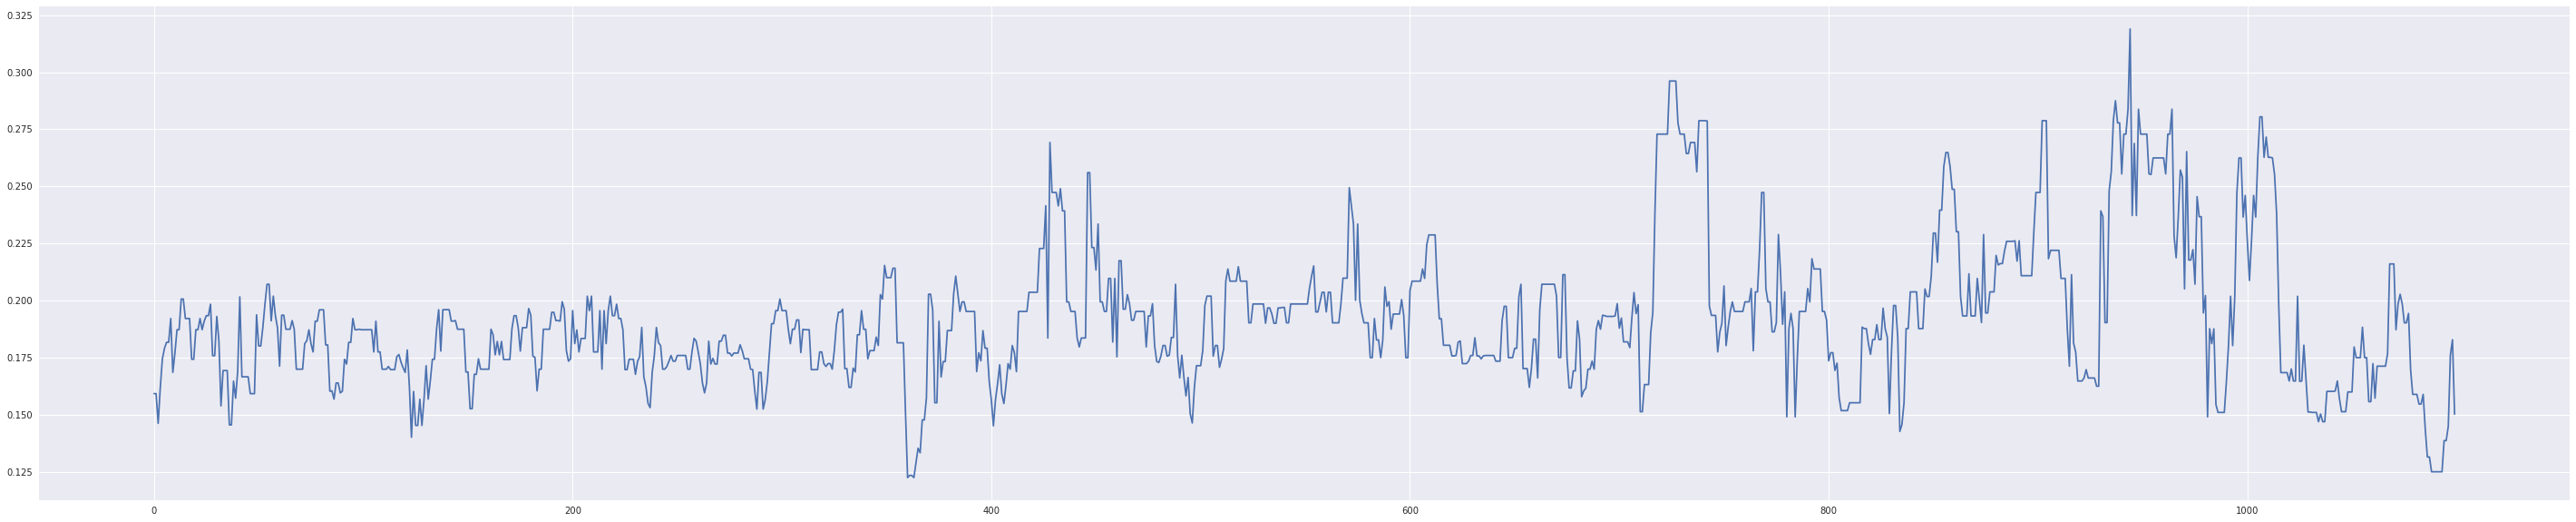

In [13]:
x = range(len(predicted))
plt.figure(figsize=(50, 10))
plt.plot(x, predicted)
plt.show()

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


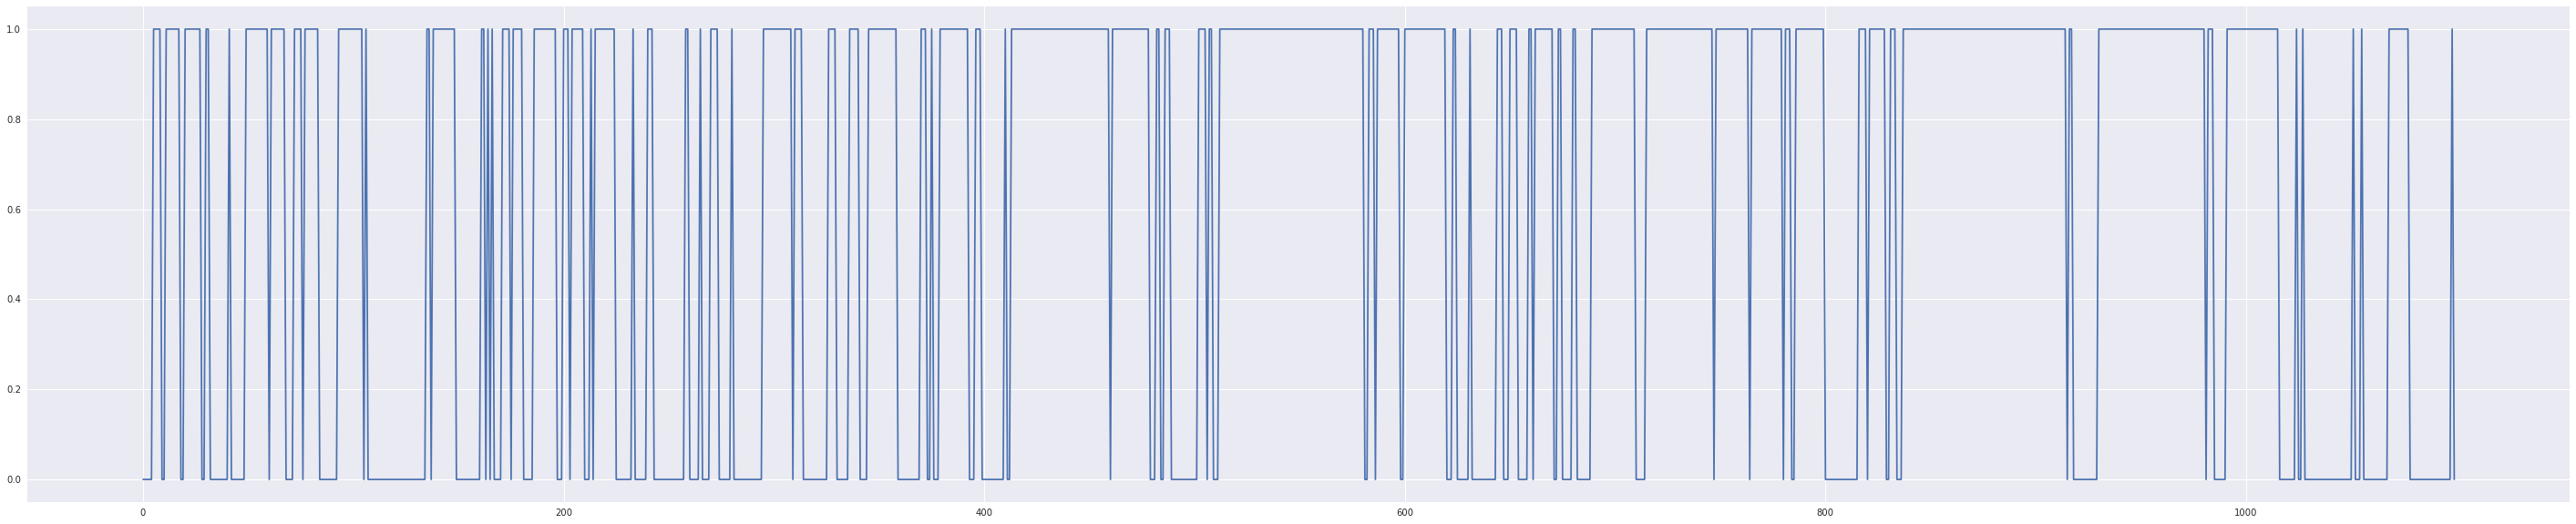

In [15]:
predicted = predictor.predict(only_features.as_matrix())
x = range(len(predicted))
plt.figure(figsize=(50, 10))
plt.plot(x, predicted)
plt.show()

In [16]:
# https://stackoverflow.com/questions/25191620/
#   creating-lowpass-filter-in-scipy-understanding-methods-and-units
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [79]:
def smooth(data):
    n = len(data)
    # Filter requirements.
    order = 6
    fs = n // 11       # sample rate, Hz
    cutoff = 2  # desired cutoff frequency of the filter, Hz
    b, a = butter_lowpass(cutoff, fs, order)
    T = 11             # seconds
    t = np.linspace(0, T, n, endpoint=False)
    # Filter the data, and plot both the original and filtered signals.
    return  butter_lowpass_filter(data, cutoff, fs, order)

def plot_smooth(data, labels):
    labels = labels / 3 
    n = len(data)
    y = smooth(data)
    T = 11             # seconds
    t = np.linspace(0, T, n, endpoint=False)

    
    plt.figure(figsize=(50, 30))
    plt.subplot(2, 1, 2)
    plt.plot(t, data, 'b-', label='data')
    plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
    plt.plot(t, labels, 'r-', label='actual data')
#     plt.ylim([0.1, 0.35])

    plt.xlabel('Time [sec]')
    plt.grid()
    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


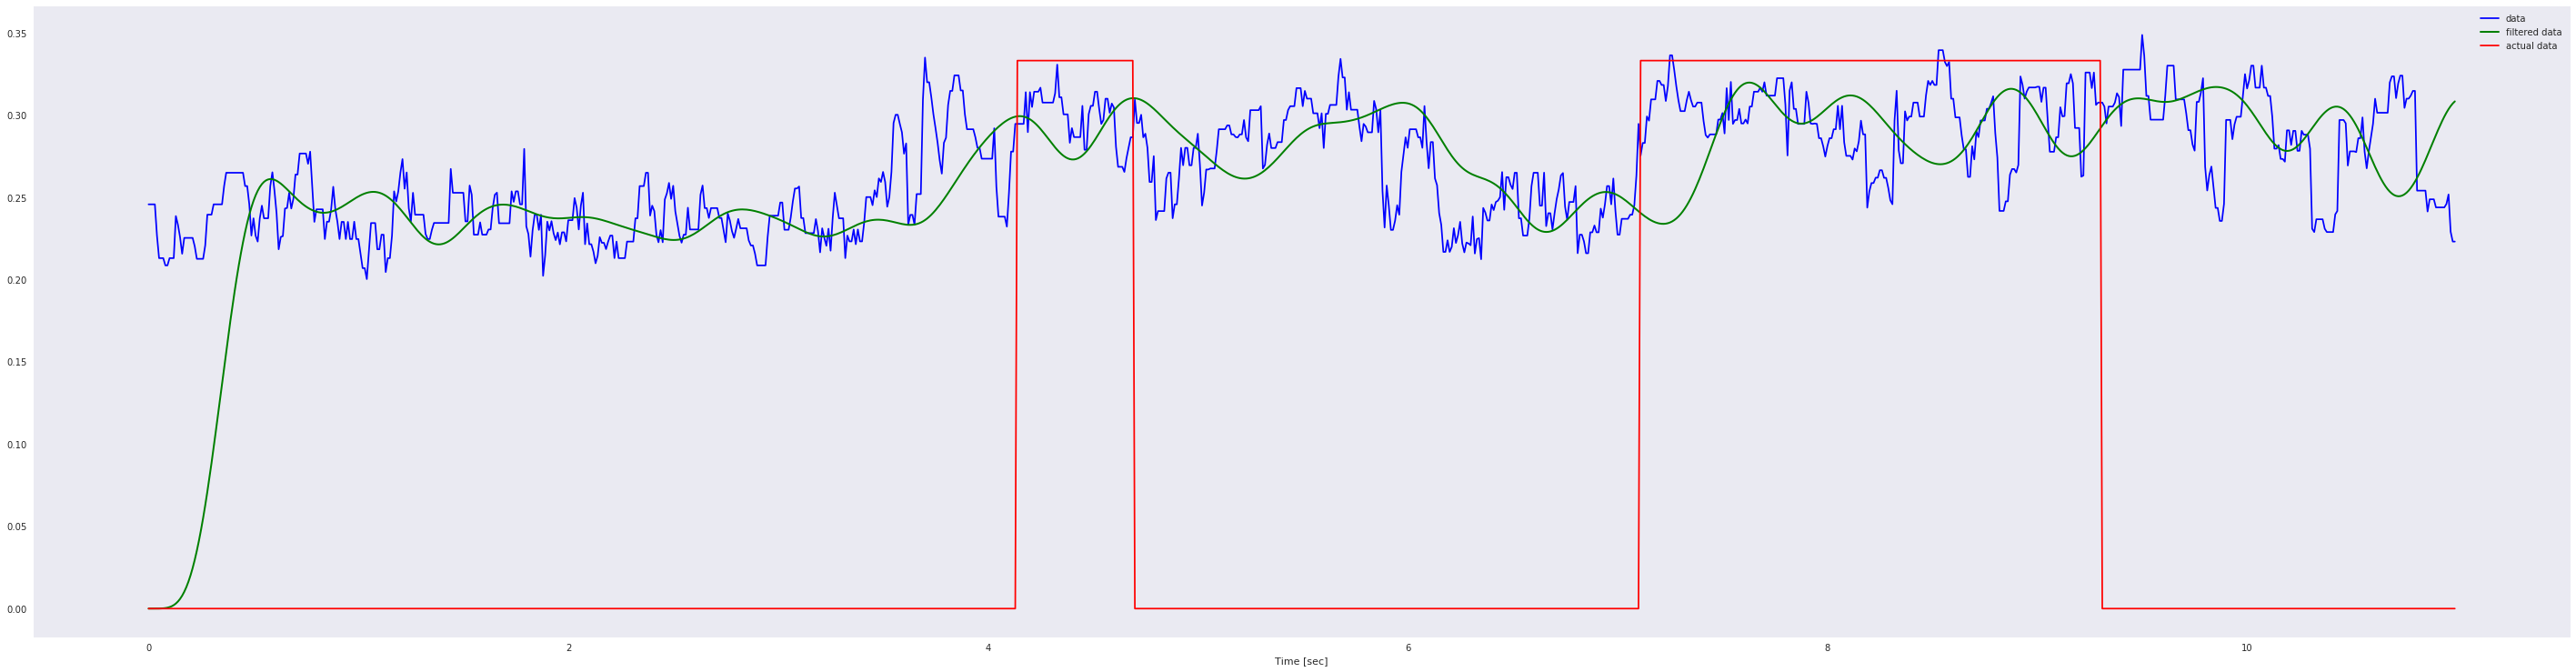

In [80]:
predicted = predictor.predict_proba(only_features.as_matrix())
plot_smooth(predicted, dff.IS_LAUGHTER)

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


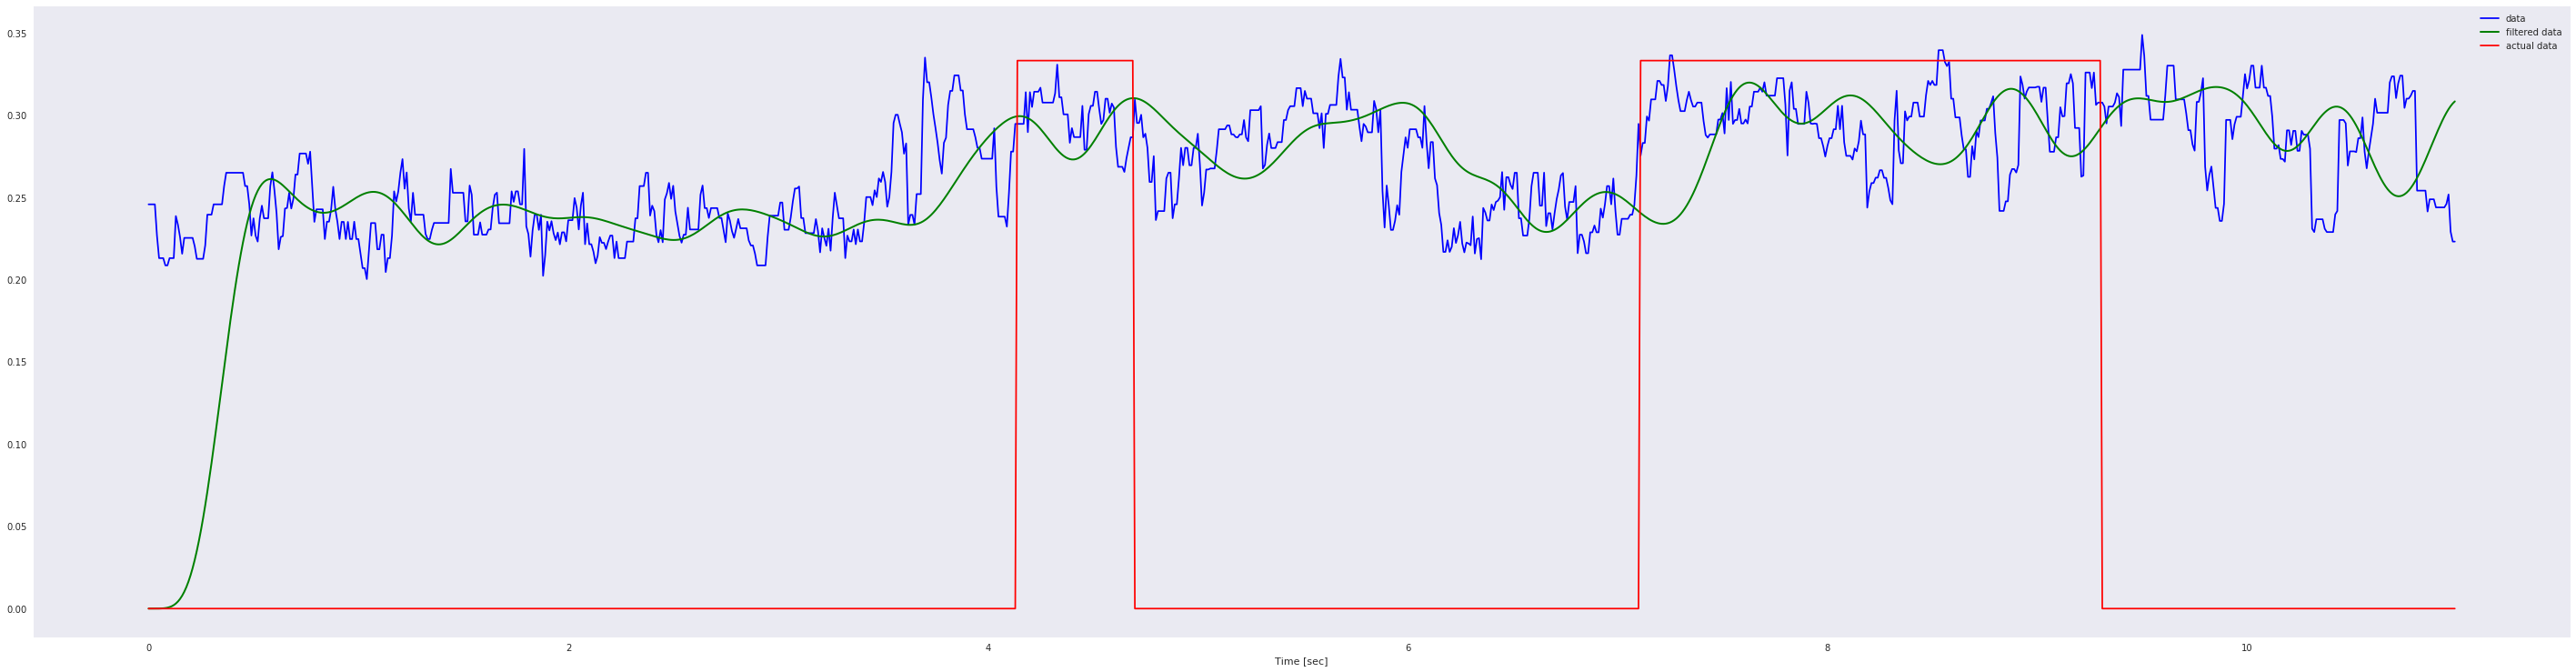

In [81]:
predictor = StrictLargeXgboostPredictor()
predicted = predictor.predict_proba(only_features.as_matrix())
plot_smooth(predicted, dff.IS_LAUGHTER)

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


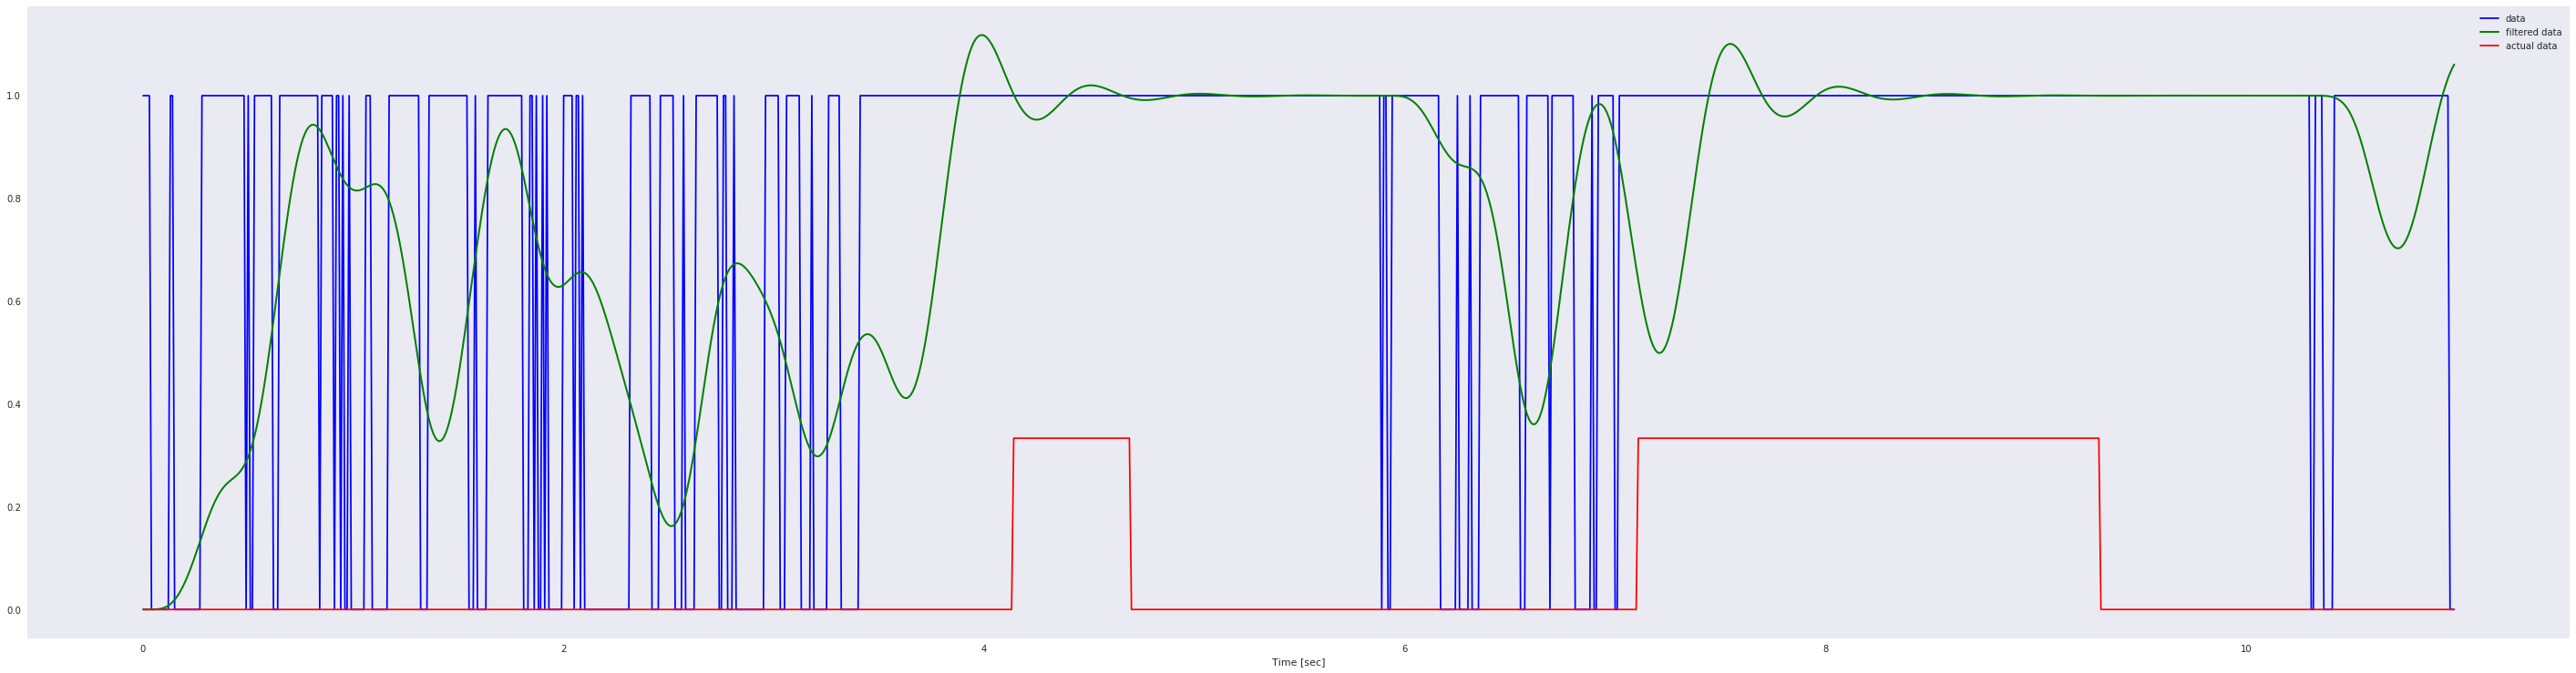

In [83]:
predictor = StrictLargeXgboostPredictor()
predicted = predictor.predict(only_features.as_matrix())
plot_smooth(predicted, dff.IS_LAUGHTER)

In [62]:
nrows = 50000
features_df = pd.read_csv("../features/feaures_pyAA_all_10ms.csv", nrows=nrows)
# features_df = pd.read_csv("../features/feaures_pyAA_all_10ms.csv")
nfeatures = features_df.shape[1] - 2
X = features_df.iloc[:, :nfeatures].as_matrix()
y = features_df.IS_LAUGHTER.as_matrix()

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [63]:
X.shape

(50000, 102)

In [64]:
model = MiniXgboostPredictor().clf

In [65]:
y_pred = smooth(model.predict_proba(X))

In [66]:
comp_df = pd.DataFrame({'y_pred' : y_pred[:, 1], 'y' : y})
comp_df.describe()

y        y_pred
count  50000.000000  5.000000e+04
mean       0.020960  8.014047e-17
std        0.143252  5.612681e-18
min        0.000000  2.148162e-17
25%        0.000000  8.031640e-17
50%        0.000000  8.193695e-17
75%        0.000000  8.250436e-17
max        1.000000  8.317174e-17

In [68]:
predictions = smooth(model.predict_proba(X))
sklearn.metrics.roc_auc_score(y, predictions[:, 1])

0.074381634478517047

In [51]:
X = dff.iloc[:, :nfeatures]
X = StandardScaler().fit_transform(X)
y = dff.IS_LAUGHTER

In [59]:
print("ACC   :", sklearn.metrics.accuracy_score(predictor.predict(X), y))
print("PREC  :", sklearn.metrics.precision_score(predictor.predict(X), y))
print("RECALL:", sklearn.metrics.recall_score(predictor.predict(X), y))

ACC   : 0.764545454545
PREC  : 0.148550724638
RECALL: 0.630769230769
